In [1]:
topic =  'Food, Cafes and Restaurants'
concept_type = 'item'

In [2]:
%cd ..

/home/eugene/Documents/wonderslide-interior-generation


# Manual eval interface

In [3]:
import os
from PIL import Image
import shutil
from tqdm.notebook import tqdm
from IPython.display import display
from IPython.display import clear_output

def validate_images(dir, start=0, end=None):
    delete_dir_path = os.path.join(dir, 'delete')
    aside_dir_path = os.path.join(dir, 'put_aside')
    os.makedirs(delete_dir_path, exist_ok=True)
    os.makedirs(aside_dir_path, exist_ok=True)
    fnames = [fname for fname in sorted(os.listdir(dir)) if fname.endswith('.png')]
    if end:
        fnames_slice = fnames[start:end]
    else:
        fnames_slice = fnames[start:]
    del_aside_count = 0
    for i, fname in tqdm(enumerate(fnames_slice, start = start)):
        clear_output()
        path = os.path.join(dir, fname)
        image = Image.open(path)
        display(image)
        progress = round(((i + 1)/len(fnames))*100)
        print(f'Image {i + 1} of {len(fnames)} ({progress}%)\n'
              f'{fname}\n'
              f'{del_aside_count} pictures were deleted or put aside. '
              f'Current index is {i - del_aside_count}.\n')
        verdict = input('Press:\n1 to delete the image,\n2 to put it aside,\n3 to keep it\n')
        if verdict == '1':
            shutil.move(path, os.path.join(delete_dir_path, fname))
            del_aside_count += 1
        elif verdict == '2':
            shutil.move(path, os.path.join(aside_dir_path, fname))
            del_aside_count += 1

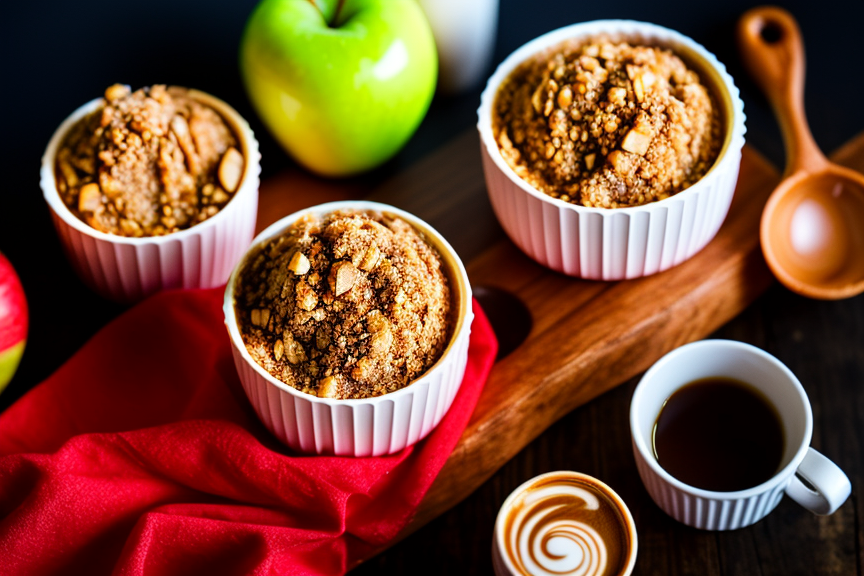

Image 1 of 3 (33%)
apple_ the apple's crisp red skin_913889_gs10_46_steps.png
0 pictures were deleted or put aside. Current index is 0.



KeyboardInterrupt: Interrupted by user

In [4]:
validate_images(dir=f'images/{topic}/{concept_type}', start=0)

# Find duplicates

In [5]:
import os
import shutil
from PIL import Image
from IPython.display import display, clear_output
from collections import defaultdict

def load_duplicates(topic, concept_type):
    SEP = '------------------'
    duplicates = [[]]
    duplicate_path = os.path.join('duplicates', topic, f'{concept_type}.txt'
                                 )
    with open(duplicate_path) as f:
        lines = f.readlines()[2:]
        for line in lines:
            line = line.strip('\n')
            if line == SEP:
                duplicates.append([])
            else:
                duplicates[-1].append(line)
    return duplicates

def group_duplicates(duplicates):
    diplicate_dict = defaultdict(list)
    for pair in duplicates:
        if pair:
            diplicate_dict[pair[0]].append(pair[1])
    duplicate_groups = []
    for k, v in diplicate_dict.items():
        duplicate_groups.append(v + [k])
    return duplicate_groups

def delete(paths, topic, concept_type):
    delete_dir_path = os.path.join('images',topic, concept_type, 'deleted_duplicates')
    os.makedirs(delete_dir_path, exist_ok=True)
    for path in paths:
        fname = path.split('/')[-1]
        shutil.move(path, os.path.join(delete_dir_path, fname))

def compare_duplicates(start=0, group=True, **kwargs):
    duplicates = load_duplicates(**kwargs)
    if group:
        duplicates = group_duplicates(duplicates)
    for i, group in enumerate(duplicates[start:], start=start):
        group = [path for path in group if os.path.exists(path)]
        if len(group)> 1:
            clear_output()
            progress = round((i/(len(duplicates)-1))*100)
            print(f'Image {i} of {len(duplicates)-1} ({progress}%)\n')
            for j, path in enumerate(group, start=1):
                print(f'Image №{j} ({path})')
                image = Image.open(path)
                display(image)
            n = len(group)
            verdict = input(f'Press the numbers (1-{n}) of images to DELETE. They must be separated by spaces.\n'
                 f'Press "d" to DELETE all images or "s" to SAVE all images.')
            if verdict == 'd':
                      delete(group, **kwargs)
            elif verdict!='s':     
                      numbers_to_delete = set(map(int, verdict.split(' ')))
                      #all_numbers = set(range(1, n+1))
                      #numbers_to_delete = all_numbers - numbers_to_save
                      files_to_delete = [group[j-1] for j in numbers_to_delete]
                      delete(files_to_delete, **kwargs)
                  

In [7]:
import os
os.makedirs(f"duplicates/{topic}", exist_ok=True)
th = 0.5
script = f'python3 aillustrate/image_finder.py ./images/"{topic}"/"{concept_type}"/ --th {th} > duplicates/"{topic}"/"{concept_type}".txt'
os.system(script);

In [8]:
compare_duplicates(topic=topic, concept_type=concept_type, start=3)

# Remove full duplicates

In [9]:
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

def find_duplicates(dir, delete = False):
    num_duplicates = 0
    fnames = os.listdir(dir)
    initial_length = len(fnames)
    prefixes = set([fname.split('_')[0] for fname in fnames if fname.endswith('.png')])
    tq = tqdm(prefixes)
    for prefix in tq:
        tq.set_description(prefix)
        cur_prefix_fnames = [fname for fname in fnames if fname.startswith(prefix)]
        path = os.path.join(dir, cur_prefix_fnames[0])
        images = [np.zeros_like(np.array(Image.open(path)))]
        for fname in cur_prefix_fnames:
            path = os.path.join(dir, fname)
            image = np.array(Image.open(path))
            if np.any(np.all(image == images, axis=1)):
                num_duplicates += 1
                if delete:
                    os.remove(path)
                    print(f'Deleted a duplicate: {fname}')
                else:
                    print(f'Found a duplicate: {fname}')
                
            else:
                images.append(image)
    
    if delete:
        final_length = len(os.listdir(dir))
        print(f'Deleted {initial_length - final_length} duplicates')
    else:
        print(f'Found {num_duplicates} duplicates')

In [10]:
find_duplicates(dir='images/Business and office', delete=True)

0it [00:00, ?it/s]

Deleted 0 duplicates


In [224]:
import torch
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch32")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

In [229]:
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
def select_max_clipscore(dir_path, prompt='', negative_prompt=''):
    assert prompt or negative_prompt, 'Please provide a prompt'
    positive_score = negative_score = 0
    images = []
    score_dict = {}
    fnames = [fname for fname in os.listdir(dir_path) if not fname.startswith('.')]
    for fname in tqdm(fnames[20:40]):
        path = os.path.join(dir_path, fname)
        image = np.array(Image.open(path))
        if prompt:
            positive_score = calculate_clip_score(np.expand_dims(image, axis=0), prompt)
        if negative_prompt:
            negative_score = calculate_clip_score(np.expand_dims(image, axis=0), negative_prompt)
        score = positive_score - negative_score
        score_dict.update({fname:score})
    return dict(reversed(sorted(score_dict.items(), key=lambda x: x[1])))

In [230]:
import re
import json
import warnings
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.disabled = True

topic = 'Business and office'
concept_type = 'interior'
with open('prompts/neg_prompts.json') as jf:
    neg_prompt = json.load(jf)[concept_type]
neg_prompt = re.sub(':[0-9\.]+', '', neg_prompt)[:300]
clipscores = select_max_clipscore(os.path.join('images', topic, concept_type), 
                                  prompt = f'high quality, coherent, beautiful, aesthetic, high resolution',
                                  negative_prompt = neg_prompt)

  0%|          | 0/20 [00:00<?, ?it/s]

In [231]:
clipscores

{'printer room_ in the_0_gs8_42_steps.png': 21.0507,
 "administrative assistant's office_ the sleek,_0_gs7_34_steps.png": 20.0939,
 'meeting room_ a modern_0_gs8_69_steps.png': 19.7882,
 'reception desk_ an elegant,_0_gs10_68_steps.png': 19.6451,
 'accounting office_ accounting office_0_gs9_39_steps.png': 19.5026,
 'cubicle area_ the sleek_0_gs7_38_steps.png': 19.4583,
 'office kitchen_  "Metro-themed,_0_gs9_37_steps.png': 19.4077,
 'client meeting space_ "An elegant_0_gs9_38_steps.png': 19.2465,
 'copier room_ glossy black_0_gs11_45_steps.png': 19.1836,
 'executive office_ a modern_0_gs9_68_steps.png': 18.9576,
 'filing cabinet_ high-tech filing_0_gs10_45_steps.png': 18.8875,
 'finance room_ dark wooden_0_gs8_29_steps.png': 18.7737,
 'sales floor_ "Sleek flooring,_0_gs7_66_steps.png': 18.5878,
 'copy room_ "A stylish_0_gs8_58_steps.png': 18.5601,
 'design studio_ an office_0_gs7_69_steps.png': 18.4952,
 'corporate office_ a contemporary_0_gs11_67_steps.png': 18.126,
 'sales area_ the 

In [ ]:
clipscores
display_ranged(os.path.join('images', topic, concept_type), clipscores)

In [199]:
import re
re.sub(':[0-9\.]+', '',neg_prompt)

'bad perspective, bad typography: 1.5, unreal engine, render, unrealistic, deformed, curved, absent parts, people, cloned objects, grained, low resolution, empty, wierd, unusual position, improper alignment, misaligned partsб macabre elements, flawed shape, added components, people, asymmetrical, broken, cartoon, collapsed, distorted perspective, improper proportion, incomplete, incorrect geometry, low quality, misaligned parts, mutated, surreal, overlapped'

In [128]:
from IPython.display import display

def dispaly_images(fnames, dir_path):
    for fname in fnames:
        path = os.path.join(dir_path, fname)
        image = Image.open(path)
        display(image)
        
def display_ranged(dir_path, scores, best=20, worst=20):
    fnames = list(scores.keys())
    print(f'Best {best} examples')
    dispaly_images(fnames[:best], dir_path)
    print(f'Worst {worst} examples')
    dispaly_images(fnames[-worst:], dir_path)

In [ ]:
display_ranged(os.path.join('images','Business and office','item'), clipscores)

In [ ]:
dir_path = 
clipscores

In [31]:
!git clone https://github.com/hichoe95/Artifact-Detection-and-Sequential-Ablation

Cloning into 'Artifact-Detection-and-Sequential-Ablation'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 321 (delta 6), reused 2 (delta 0), pack-reused 309
Receiving objects: 100% (321/321), 80.85 MiB | 8.95 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [44]:
from artifact_detection.models.pggan_discriminator import PGGANDiscriminator 

In [84]:
image = Image.open(os.path.join('images','Business and office', 'item', 'paper_ paper_0_gs7_40_steps.png'))

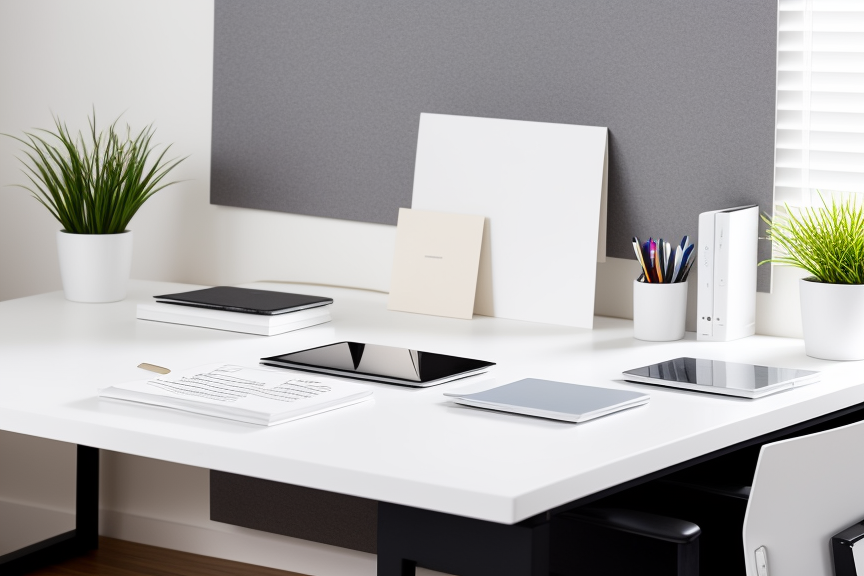

NameError: name 'patches' is not defined

In [86]:
display(image)
display(image.crop((0, 0, 512, 512)))
display(image.crop((352, 0, 864, 512)))
display(image.crop((0, 64, 512, 576)))
display(image.crop((352, 64, 864, 576)))

In [108]:
def crop_image(image):
    patches = []
    patches.append(image.crop((0, 0, 512, 512))) #left top
    patches.append(image.crop((352, 0, 864, 512))) #right top
    patches.append(image.crop((0, 64, 512, 576))) #left bottom
    patches.append(image.crop((352, 64, 864, 576))) #right bottom
    return patches

def prepare_image(path):
    image = Image.open(path)
    patches = crop_image(image)
    patches = torch.tensor(np.stack([np.array(image) for image in patches]), dtype=torch.float32)
    patches = patches.permute((0, 3, 1, 2))
    return patches

In [134]:
from artifact_detection.models.pggan_discriminator import PGGANDiscriminator
from artifact_detection.models.stylegan2_discriminator import StyleGAN2Discriminator
discriminator = StyleGAN2Discriminator(512)

In [109]:
patches = prepare_image(os.path.join('images','Business and office', 'item', 'paper_ paper_0_gs7_40_steps.png'))

In [115]:
torch.mean(discriminator.forward(patches)).item()

110.93584442138672

In [125]:
def calculate_gan_score(path):
    patches = prepare_image(path)
    return torch.mean(discriminator.forward(patches)).item()

In [132]:
def select_max_ganscore(dir_path):
    images = []
    score_dict = {}
    fnames = [fname for fname in os.listdir(dir_path) if not fname.startswith('.')]
    for fname in tqdm(fnames):
        path = os.path.join(dir_path, fname)
        image = np.array(Image.open(path))
        score = calculate_gan_score(path)
        score_dict.update({fname:score})
    return dict(sorted(score_dict.items(), key=lambda x: x[1]))

In [135]:
dir_path = os.path.join('random good examples','Business and office', 'item')
ganscores = select_max_ganscore(dir_path)
display_ranged(dir_path, ganscores, best=8, worst=1)

  0%|          | 0/9 [00:00<?, ?it/s]

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [127]:
ganscores

{'A white board featuring a long_89.png': 108.2107925415039,
 'A white board featuring a long_72.png': 106.91386413574219,
 'pen: an elegant black pen perched.png': 106.19905090332031,
 'administrative building exterior: an imposing steel.png': 90.72940063476562,
 'Create a visually stunning image featuring_17.png': 80.12664794921875,
 'pen: a white gel pen rests.png': 77.25763702392578,
 'Create a visually stunning image featuring.png': 76.24420166015625,
 'planner: the sleek wooden desk stands,.png': 69.1995849609375,
 'keyboard: keyboard with ergonomic shape and.png': 68.26114654541016}

In [185]:
%cd artifact_detection
from config import parse_args
from artifact_detection.model import pggan, stylegan2
from artifact_detection.seq_abl import sequential_ablation

args = parse_args(jupyter = True)
args.resolution = 256
args.weight_path = './stylegan2_church256.pth'
device = f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu'
G, _ = stylegan2(args.weight_path, args.resolution)
sq = sequential_ablation(G, device, args)

[Errno 2] No such file or directory: 'artifact_detection'
/home/eugene/Documents/wonderslide-interior-generation/artifact_detection
Frequencies of the neurons are loaded !


100%|██████████| 4/4 [00:00<00:00,  7.63it/s]


In [176]:
args.model = 'pggan'
args

Namespace(gpu=0, batch_size=30, sample_size=30000, freq_path='./stats', model='pggan', dataset='ffhq', resolution=1024, weight_path='./stylegan2_ffhq1024.pth', detection=True, correction=True)

In [174]:
from config import parse_args
args = parse_args(jupyter = True)
args

Namespace(gpu=0, batch_size=30, sample_size=30000, freq_path='./stats', model='stylegan2', dataset='ffhq', resolution=1024, weight_path='./stylegan2_ffhq1024.pth', detection=True, correction=True)

In [186]:
norm, arti = sq.arti_detection(layer_idx = [0,1,3], sample_num = 12000, topn = 60)

100%|██████████| 400/400 [02:20<00:00,  2.85it/s]


In [171]:
from importlib import reload
from artifact_detection import config
reload(config)

<module 'artifact_detection.config' from '/home/eugene/Documents/wonderslide-interior-generation/artifact_detection/config.py'>